In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pathlib

In [20]:
for results_file in Path(os.getcwd()+os.path.sep+'models_results').rglob('*.csv'):
    if 'point' in str(results_file):
        print(results_file)

/home/ido/data/idc/deep learning/vad/models_results/.ipynb_checkpoints/naive_net-checkpoint.csv
/home/ido/data/idc/deep learning/vad/models_results/.ipynb_checkpoints/basic_rnn_no_delta_training-checkpoint.csv


In [21]:
results = []
for results_file in Path(os.getcwd()+os.path.sep+'models_results').rglob('*.csv'):
    if 'training' in str(results_file):continue
    if '.ipynb' in str(results_file):continue
    results_df = pd.read_csv(results_file)
    if not 'base_name' in results_df.columns:
        results_df['base_name']=results_df['file_number']
    results_df = results_df[['base_name' ,'noise','snr','accuracy']]
    file_name = str(results_file).rsplit(os.path.sep)[-1].split('.')[0]
    results_df['model_name'] = file_name
    results_df['batch'] = results_df['model_name'].str.contains('batch')
    results_df['no_delta'] = results_df['model_name'].str.contains('no_delta')
    results.append(results_df)
    
models_performances = pd.concat(results)
print(len(models_performances))
models_performances.head()

97774


,base_name,noise,snr,accuracy,model_name,batch,no_delta
0,ch1_3752-4944-0008.gzip,pink,12,100.000000,batch_rnn_no_delta,True,True
1,ch1_3752-4944-0008.gzip,white,12,100.000000,batch_rnn_no_delta,True,True
2,ch1_84-121123-0000.gzip,car80,12,99.230769,batch_rnn_no_delta,True,True
3,ch1_84-121123-0000.gzip,car80,6,99.230769,batch_rnn_no_delta,True,True
4,ch1_84-121123-0000.gzip,white,12,98.461538,batch_rnn_no_delta,True,True


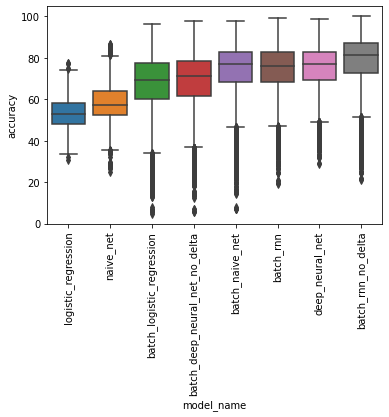

In [33]:
#so how is the best model?
order = models_performances.groupby(by=["model_name"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="model_name" ,y="accuracy",data=models_performances
            , order=order)
for label in p.get_xticklabels():
    label.set_rotation(90)
p.figure.savefig("plots/accuracy_per_model.png",dpi=300, bbox_inches = "tight")

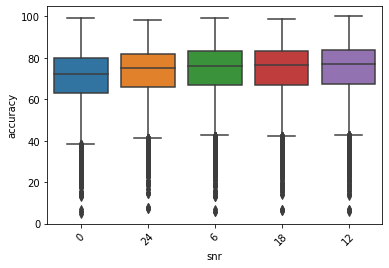

In [34]:
# sainety cheak - are we doing better the higher the snr is?
order = models_performances.groupby(by=["snr"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="snr", y="accuracy",
            data=models_performances
            , order=order)
for label in p.get_xticklabels():
    label.set_rotation(45)
p.figure.savefig("plots/accuracy_per_snr.png",dpi=300, bbox_inches = "tight")

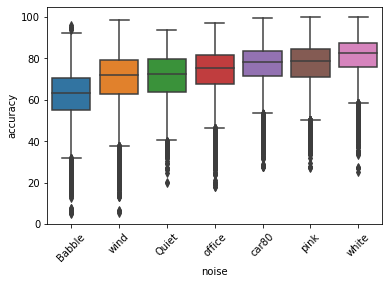

In [35]:
# which noise type is the hardest to get?
order = models_performances.groupby(by=["noise"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="noise", y="accuracy",
            data=models_performances
                ,order=order)
for label in p.get_xticklabels():
    label.set_rotation(45)
p.figure.savefig("plots/accuracy_per_noise.png",dpi=300, bbox_inches = "tight")

In [28]:
training_time = pd.read_csv('training_time.csv')
training_time['seconds'] = training_time['time']
training_time

,model,time,seconds
0,batch_rnn_no_delta,3470,3470
1,batch_rnn,3236,3236
2,batch_naive_net,202,202
3,batch_deep_neural_net_no_delta,199,199
4,batch_deep_neural_net,178,178
5,batch_logistic_regression,175,175
6,logistic_regression,15,15
7,naive_net,15,15


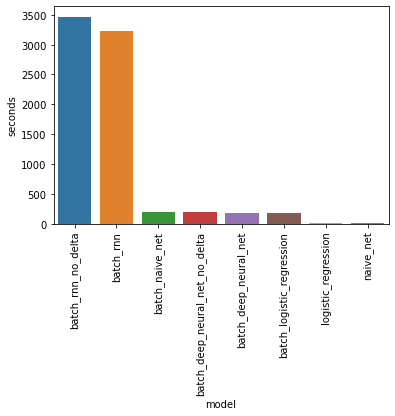

In [36]:
p = sns.barplot(x='model',y='seconds',data = training_time)
for label in p.get_xticklabels():
    label.set_rotation(90)
p.figure.savefig("plots/training_time.png",dpi=300, bbox_inches = "tight")

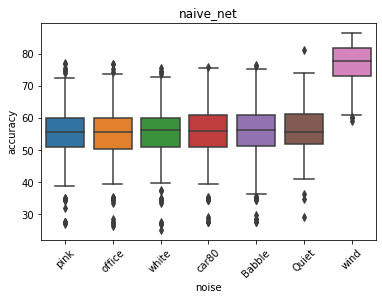

In [48]:
for model_name in models_performances['model_name'].unique():
    
    folder = pathlib.Path(f'plots/{model_name}')
    folder.mkdir(exist_ok=True)

    subseted = models_performances[models_performances['model_name']==model_name]
    
    
    order = subseted.groupby(by=["snr"])["accuracy"].mean().sort_values().index
    plt.cla()
    p = sns.boxplot(x="snr", y="accuracy",
                data=subseted
                , order=order)
    p.set_title(model_name)
    for label in p.get_xticklabels():
        label.set_rotation(45)
    p.figure.savefig(f"plots/{model_name}/accuracy_per_snr.png",dpi=300, bbox_inches = "tight")
    
    
    order = subseted.groupby(by=["noise"])["accuracy"].mean().sort_values().index
    plt.cla()
    p = sns.boxplot(x="noise", y="accuracy",
                data=subseted
                    ,order=order)
    p.set_title(model_name)
    for label in p.get_xticklabels():
        label.set_rotation(45)
    p.figure.savefig(f"plots/{model_name}/accuracy_per_noise.png",dpi=300, bbox_inches = "tight")